<a href="https://colab.research.google.com/github/goya5858/OSERO/blob/main/Test_Ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q -q -q -U 'ray[default]' 

     |████████████████████████████████| 49.4MB 80kB/s 
     |████████████████████████████████| 133kB 44.6MB/s 
     |████████████████████████████████| 10.1MB 35.6MB/s 
     |████████████████████████████████| 3.1MB 30.8MB/s 
     |████████████████████████████████| 81kB 7.8MB/s 
     |████████████████████████████████| 71kB 8.3MB/s 
     |████████████████████████████████| 1.3MB 34.4MB/s 
     |████████████████████████████████| 1.0MB 26.6MB/s 
     |████████████████████████████████| 81kB 9.1MB/s 
     |████████████████████████████████| 204kB 43.7MB/s 
     |████████████████████████████████| 92kB 9.6MB/s 
     |████████████████████████████████| 296kB 47.5MB/s 
     |████████████████████████████████| 143kB 56.2MB/s 


# 関数を並列実行

In [ ]:
import time

def worker_func(pid):
    time.sleep(5)
    return f"pid {pid} finished"

start = time.time()
results = [worker_func(i) for i in range(3)]
print(results)
print('Elapsed:', time.time()-start)

['pid 0 finished', 'pid 1 finished', 'pid 2 finished']
Elapsed: 15.014969825744629


# 分散同期処理
関数を並列で実行し、全ての処理が終わったのちに結果をまとめて出力する

In [ ]:
import ray
import time

@ray.remote
def worker_func(pid):
    time.sleep(5)
    return f"pid {pid} finished"

ray.init(ignore_reinit_error=True)
start = time.time()
results = [worker_func.remote(i) for i in range(3)]
#time.sleep(15)
print(results)
print("途中：", time.time() - start)
print( ray.get(results) )
print('Elapsed:', time.time()-start)

# ray.get()により "同期処理" を実行することができる
# remote自体を保管した result 自体をprintしても保管されたオブジェクトのみが返される
# ray.get()を使うことでそれぞれのremoteの出力を入手できる
# なお、ray.get()を使わなくても処理自体は進行しているらしい

2021-06-12 16:26:57,227	INFO services.py:1274 -- View the Ray dashboard at http://127.0.0.1:8265


[ObjectRef(a67dc375e60ddd1affffffffffffffffffffffff0100000001000000), ObjectRef(63964fa4841d4a2effffffffffffffffffffffff0100000001000000), ObjectRef(69a6825d641b4613ffffffffffffffffffffffff0100000001000000)]
途中： 0.05024313926696777
['pid 0 finished', 'pid 1 finished', 'pid 2 finished']
Elapsed: 10.103117942810059


# 非同期分散処理
関数を並列で実行し、処理が終わった順に結果を出力していく

In [ ]:
import ray
import time
import random

@ray.remote
def worker_func(pid):
    time.sleep(random.randint(3,15))
    return f"pid {pid} finished"

ray.init(ignore_reinit_error=True)
start = time.time()
work_in_progresses = [worker_func.remote(i) for i in range(10)]

for i in range(10):
    finished, work_in_progresses = ray.wait(work_in_progresses, num_returns=1)
    print(finished)
    orf = finished

    print(ray.get(orf))
    print(ray.get(orf[0]))
    print("Elapsed:", time.time()-start, "\n")

# ray.waint()で "非同期処理" ができる
# ObjectRef, work_in_progresses = ray.wait(work_in_progresses)
# で 今回終わった処理の結果を内包した"ObjectRef" と 残りの実行中の処理:work_in_progresses を入手できる
# あとは同期処理と同様に、ray.get(ObjectRef)で実際の返り値を入手できる
# なお、返り値が複数ある場合もあるので、orf[0]のように中身を取り出す

2021-06-12 16:27:13,545	INFO worker.py:737 -- Calling ray.init() again after it has already been called.


[ObjectRef(ee4e90da584ab0ebffffffffffffffffffffffff0100000001000000)]
['pid 0 finished']
pid 0 finished
Elapsed: 3.0156149864196777 

[ObjectRef(4ee449587774c1f0ffffffffffffffffffffffff0100000001000000)]
['pid 1 finished']
pid 1 finished
Elapsed: 4.016332149505615 

[ObjectRef(480a853c2c4c6f27ffffffffffffffffffffffff0100000001000000)]
['pid 3 finished']
pid 3 finished
Elapsed: 15.028555870056152 

[ObjectRef(32cccd03c567a254ffffffffffffffffffffffff0100000001000000)]
['pid 2 finished']
pid 2 finished
Elapsed: 16.02357506752014 

[ObjectRef(623b26bdd75b28e9ffffffffffffffffffffffff0100000001000000)]
['pid 4 finished']
pid 4 finished
Elapsed: 18.035106420516968 

[ObjectRef(1e9d04d3b7e4dfb2ffffffffffffffffffffffff0100000001000000)]
['pid 5 finished']
pid 5 finished
Elapsed: 30.038304567337036 

[ObjectRef(609d7f556b6757adffffffffffffffffffffffff0100000001000000)]
['pid 6 finished']
pid 6 finished
Elapsed: 33.05211091041565 

[ObjectRef(402ddcfdf56ca87affffffffffffffffffffffff01000000010000

# クラスを利用したクラス単位でのサブプロセス化

In [ ]:
import ray
import random
import time

@ray.remote
class Worker:
    def __init__(self, worker_id):
        self.worker_id = worker_id
        self.n = 0 #オブジェクトの保存する変数
    def add(self, n):
        #5秒間待ってからオブジェクトの保存しているself.nに数字を足す作業を行う
        time.sleep(self.worker_id)
        self.n += n
    def get_value(self):
        return f"Process: {self.worker_id}, value: {self.n}"




ray.init(ignore_reinit_error=True)
start = time.time()

workers = [ Worker.remote(i) for i in range(5) ] 
# それぞれ5秒待ってからself.nに5を足すタスクを実行させる
for worker in workers:
    worker.add.remote(5)

for worker in workers:
    print(ray.get( worker.get_value.remote() ))
#workers = ray.get( workers )
print("Elapsed:", time.time()-start)

# それぞれ5秒待ってからself.nに10を足すタスクの実行命令を出す
for worker in workers:
    worker.add.remote(10)

for i, worker in enumerate(workers):
    print(f"start_num_{i}")
    print(ray.get( worker.get_value.remote() ))
#workers = ray.get( workers )
print("Elapsed:", time.time()-start)

# Classを用いることで内部情報を保存した実行を行うことができる
# @ray.remoteで修飾されたクラスを"Actor"といい、各Actorにはremoteメソッドを使うことで処理の実行開始命令を行うことができる
# remoteメソッドで行うのは処理の実行開始命令だけで、命令を出す順番はfor文等に依存する
# ray.get( worker.get_value.remote() )では各プロセスが終了すれば返り値をくれる

2021-06-12 16:45:52,021	INFO worker.py:737 -- Calling ray.init() again after it has already been called.


Process: 0, value: 5
Process: 1, value: 5
Process: 2, value: 5
Process: 3, value: 5
Process: 4, value: 5
Elapsed: 6.406382322311401
start_num_0
Process: 0, value: 15
start_num_1
Process: 1, value: 15
start_num_2
Process: 2, value: 15
start_num_3
Process: 3, value: 15
start_num_4
Process: 4, value: 15
Elapsed: 10.412129878997803


# クラスでの分散同期処理

In [ ]:
import ray
import random
import time

@ray.remote
class Worker:
    def __init__(self, worker_id):
        self.worker_id = worker_id
        self.n = 0 #オブジェクトの保存する変数
    def add(self, n):
        #5秒間待ってからオブジェクトの保存しているself.nに数字を足す作業を行う
        time.sleep(self.worker_id)
        self.n += n
    def get_value(self):
        return f"Process: {self.worker_id}, value: {self.n}"




ray.init(ignore_reinit_error=True)
start = time.time()

workers = [ Worker.remote(i) for i in range(5) ] 
# それぞれ5秒待ってからself.nに5を足すタスクを実行させる
for worker in workers:
    worker.add.remote(5)

# それぞれ5秒待ってからself.nに10を足すタスクの実行命令を出す
for worker in workers:
    worker.add.remote(10)

results = [ worker.get_value.remote() for worker in workers ]
results = ray.get( results )
print(results)
print("Elapsed:", time.time()-start)

# results = [ worker.get_value.remote() for worker in workers ]
# でObjectRefのリストを作成している
# ray.get()ではActor自身は引数にできず、ORefを対象とする
# results = ray.get( results )で終了を同期している

2021-06-12 16:54:53,369	INFO worker.py:737 -- Calling ray.init() again after it has already been called.
2021-06-12 16:54:53,399	WARNING worker.py:1114 -- WARNING: 22 PYTHON workers have been started on a node of the id: fa44040dc1aac70bb253d28d89d17c364687cd295990866622ef57b6 and address: 172.28.0.2. This could be a result of using a large number of actors, or it could be a consequence of using nested tasks (see https://github.com/ray-project/ray/issues/3644) for some a discussion of workarounds.


['Process: 0, value: 15', 'Process: 1, value: 15', 'Process: 2, value: 15', 'Process: 3, value: 15', 'Process: 4, value: 15']
Elapsed: 10.832329750061035


# クラスでの分散非同期

In [ ]:
import ray
import random
import time

@ray.remote
class Worker:
    def __init__(self, worker_id):
        self.worker_id = worker_id
        self.n = 0 #オブジェクトの保存する変数
    def add(self, n):
        #5秒間待ってからオブジェクトの保存しているself.nに数字を足す作業を行う
        time.sleep(random.randint(1,10))
        self.n += n
    def get_value(self):
        return f"Process: {self.worker_id}, value: {self.n}"




ray.init(ignore_reinit_error=True)
start = time.time()

workers = [ Worker.remote(i) for i in range(5) ] 
# それぞれ5秒待ってからself.nに5を足すタスクを実行させる
for worker in workers:
    worker.add.remote(5)

# それぞれ5秒待ってからself.nに10を足すタスクの実行命令を出す
for worker in workers:
    worker.add.remote(10)

work_in_progresses = [ worker.get_value.remote() for worker in workers ]

for _ in range( len(work_in_progresses) ):
    finished, work_in_progresses = ray.wait(work_in_progresses, num_returns=1)
    orf = finished
    print(ray.get(orf[0]))
    print("Elapsed:", time.time()-start, "\n")

# work_in_progresses = [ worker.get_value.remote() for worker in workers ]
# で実行中のObjectRefのリストを作成している
# あとは実行中の処理が終わるたびに結果と残りの処理を受け取っていく

2021-06-12 17:03:17,712	INFO worker.py:737 -- Calling ray.init() again after it has already been called.


Process: 1, value: 15
Elapsed: 7.995789289474487 

Process: 3, value: 15
Elapsed: 9.906349420547485 

Process: 0, value: 15
Elapsed: 9.934542655944824 

Process: 4, value: 15
Elapsed: 11.634456396102905 

Process: 2, value: 15
Elapsed: 20.9136381149292 



# Pytorchでの同期分散処理

In [17]:
import torch
import torch.nn as nn
from torch.optim import Adam
import numpy as np
import torch.nn.functional as F

import ray
import random
import time

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

class Net(nn.Module):
    """Small ConvNet for MNIST."""

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2,4)
        self.act1 = nn.ReLU()
        self.fc3 = nn.Linear(4, 1)

        self.metrics = nn.MSELoss()  
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc3(x)
        return x

    def get_weights(self):
        return {k: v.cpu() for k, v in self.state_dict().items()}

    def set_weights(self, weights):
        self.load_state_dict(weights)

    def get_gradients(self):
        grads = []
        for p in self.parameters():
            grad = None if p.grad is None else p.grad.data.cpu().numpy()
            grads.append(grad)
        return grads

    def set_gradients(self, gradients):
        for g, p in zip(gradients, self.parameters()):
            if g is not None:
                p.grad = torch.from_numpy(g)

In [18]:
def get_Data():
    Data = []
    for i in range(1024):
        a = random.randint(1,30)
        b = random.randint(1,30)
        c = 3*a+b
        Data.append([a,b,c])

    Data = torch.tensor(Data, dtype=torch.float)
    return Data[:,:2], Data[:,2].reshape(-1,1)

In [23]:
#@ray.remote
class ParameterServer(object):
    def __init__(self, lr):
        self.model = Net()
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=lr)

    def apply_gradients(self, *gradients):
        summed_gradients = [
            np.stack(gradient_zip).mean(axis=0) for gradient_zip in zip(*gradients)
        ]
        self.optimizer.zero_grad()
        self.model.set_gradients(summed_gradients)
        self.optimizer.step()
        return self.model.get_weights()

    def get_weights(self):
        return self.model.get_weights()

In [19]:
@ray.remote
class DataWorker(object):
    def __init__(self):
        self.model = Net()

    def compute_gradients(self, weights, data):
        self.model.set_weights(weights)
        X, y = data[0], data[1]
        self.model.zero_grad()
        pred = self.model(X)
        loss = F.mse_loss(pred, y)
        loss.backward()
        return self.model.get_gradients()

In [26]:
import random
iterations = 100
num_workers = 8

ray.init(ignore_reinit_error=True)
#ps = ParameterServer.remote(lr=5e-2)
ps = ParameterServer(lr=5e-2)
workers = [DataWorker.remote() for i in range(num_workers)]
Datas  = [ get_Data() for _ in range(num_workers)]

print("Running synchronous parameter server training.")
model = Net()
#current_weights = ps.get_weights.remote()
current_weights = ps.get_weights()
for i in range(iterations):
    gradients = [
        worker.compute_gradients.remote(current_weights, data) for worker, data in zip(workers, Datas)
    ]
    # Calculate update after all gradients are available.
    #current_weights = ps.apply_gradients.remote(*gradients)
    gradients = ray.get(gradients)
    current_weights = ps.apply_gradients(*gradients)

    if i % 10 == 0:
        # Evaluate the current model.
        X_test, y_test = Datas[0]
        #model.set_weights(ray.get(current_weights))
        model.set_weights(current_weights)
        pred = model(X_test)
        loss = F.mse_loss(pred, y_test)
        print("Iter {}: \tloss is {:.1f}".format(i, loss))

ray.shutdown()

2021-06-13 06:57:23,450	INFO worker.py:737 -- Calling ray.init() again after it has already been called.


Running synchronous parameter server training.
Iter 0: 	loss is 5653.0
Iter 10: 	loss is 1246.0
Iter 20: 	loss is 799.5
Iter 30: 	loss is 759.1
Iter 40: 	loss is 759.0
Iter 50: 	loss is 760.7
Iter 60: 	loss is 761.5
Iter 70: 	loss is 761.8
Iter 80: 	loss is 761.9
Iter 90: 	loss is 762.0


# Torch ミス　うまく動かない

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
import numpy as np

import ray
import random
import time

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

def get_Data():
    Data = []
    for i in range(1024):
        a = random.randint(1,30)
        b = random.randint(1,30)
        c = 3*a+b
        Data.append([a,b,c])

    Data = torch.tensor(Data, dtype=torch.float)
    return Data[:,:2], Data[:,2].reshape(-1,1)

class SharedBrain(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2,4)
        self.act1 = nn.ReLU()
        self.fc3 = nn.Linear(4, 1)

        self.metrics = nn.MSELoss()  
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc3(x)
        return x

last loss : 1.614059


Text(0.5, 1.0, 'Loss')

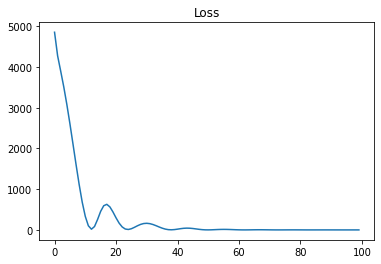

In [3]:
X, y = get_Data()

model = SharedBrain()
optim = Adam(params=model.parameters(), lr=0.1)
LOSS = []

for _ in range(100):
    optim.zero_grad()
    pred = model(X)
    loss = nn.MSELoss()(pred, y)
    loss.backward()
    optim.step()
    LOSS.append(loss.detach().numpy())

print("last loss :", loss.detach().numpy())
plt.plot( range(len(LOSS)), LOSS )
plt.title('Loss')

Elapsed: 0.5948522090911865
last loss : 0.4953204


Text(0.5, 1.0, 'Loss')

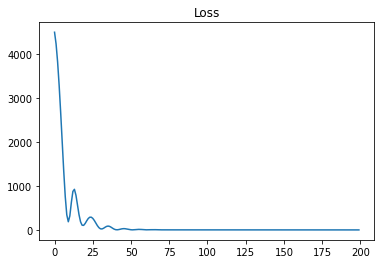

In [4]:
num_processes = 8

class TestModel:
    def __init__(self):
        pass 
    def get_loss(self, x, y, network, metrics):
        pred = network(x)
        loss = metrics(pred, y)
        return loss

shared_brain = SharedBrain()
optim = Adam(params=shared_brain.parameters(), lr=0.1)

start = time.time()
models = [ TestModel() for _ in range(num_processes) ]
Datas  = [ get_Data() for _ in range(num_processes)]

metrics = nn.MSELoss()
LOSS = []
for _ in range(200):
    optim.zero_grad()
    losses = [ models[i].get_loss( Datas[i][0], Datas[i][1], shared_brain, nn.MSELoss() ) for i in range(num_processes)]
    loss = sum( losses )/len(losses)
    loss.backward()
    optim.step()
    LOSS.append(loss.detach().numpy())

print("Elapsed:", time.time()-start)
print("last loss :", loss.detach().numpy())
plt.plot( range(len(LOSS)), LOSS )
plt.title('Loss')

2021-06-13 06:52:13,246	INFO worker.py:737 -- Calling ray.init() again after it has already been called.



Elapsed: 5.79199743270874
last loss : 4333.825


Text(0.5, 1.0, 'Loss')

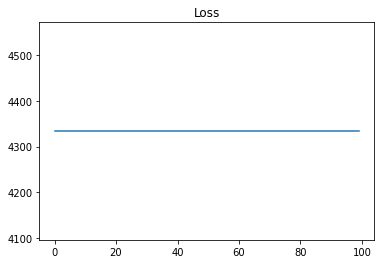

In [16]:
num_processes = 2

class SharedBrain(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2,4)
        self.act1 = nn.ReLU()
        self.fc3 = nn.Linear(4, 1)
    
        self.metrics = nn.MSELoss() 
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc3(x)
        return x

@ray.remote
class MasterModel:
    def __init__(self):
        self.Brain = SharedBrain()
        self.optim = Adam(params=self.Brain.parameters(), lr=1)
    def get_net(self):
        return self.Brain
    def step(self):
        self.optim.step()
        self.optim.zero_grad()

@ray.remote
class TestModel:
    def __init__(self):
        pass 
    def get_loss(self, x, y, network, metrics):
        pred = network(x)
        loss = metrics(pred, y)
        return loss

ray.init(ignore_reinit_error=True)
Mastermodel = MasterModel.remote()

start = time.time()
models = [ TestModel.remote() for _ in range(num_processes) ]
Datas  = [ get_Data() for _ in range(num_processes)]

metrics = nn.MSELoss()
LOSS = []
for _ in tqdm(range(100)):
    optim.zero_grad()
    losses = [ models[i].get_loss.remote( Datas[i][0], Datas[i][1], Mastermodel.get_net.remote(), metrics ) for i in range(num_processes)]
    losses = ray.get(losses)
    loss = sum( losses )/len(losses)
    loss.backward()
    Mastermodel.step.remote()
    LOSS.append(loss.detach().numpy())

print("Elapsed:", time.time()-start)
print("last loss :", loss.detach().numpy())
plt.plot( range(len(LOSS)), LOSS )
plt.title('Loss')